In [1]:
import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
yaba_properties = pd.read_json("./data/yaba-properties.json")
surulere_properties = pd.read_json("./data/surulere-properties.json")
maryland_properties = pd.read_json("./data/maryland-properties.json")
gbagada_properties = pd.read_json("./data/gbagada-properties.json")

data = pd.concat([yaba_properties, surulere_properties, maryland_properties, gbagada_properties])

In [3]:
data.head()

,type,shortDesc,link,rent,addedOn,location,marketedBy,metaProps
0,Self contained (single rooms) for rent,Luxurious And Furnished Room Self Contained,https://nigeriapropertycentre.com/for-rent/fla...,"400,000",Added on 06 Jul 2020,"Fadeyi Axis, Yaba, Lagos",\nJesutfemi Consult\n\n 08099795785 \n,"{'Bathroom': '1', 'Toilet': '1', 'Parking Spac..."
1,Self contained (single rooms) for rent,Newly Built And Luxury Self Contained Room,https://nigeriapropertycentre.com/for-rent/fla...,"400,000",Added on 10 Nov 2020,"Alagomeji, Yaba, Lagos",\nJesutfemi Consult\n\n 08099795785 \n,"{'Bathroom': '1', 'Toilet': '1', 'Parking Spac..."
2,1 bedroom mini flat for rent,A Lovely Spacious Miniflat With 2 Toilets And ...,https://nigeriapropertycentre.com/for-rent/fla...,"800,000",Added on 03 Dec 2020,"Bornoway, Adekunle, Yaba, Lagos",\nThe Property Concession Company\n\n 0802477...,{'Bedroom': '1'}
3,Self contained (single rooms) for rent,A Lovely Luxury Roomself Contained,https://nigeriapropertycentre.com/for-rent/fla...,"500,000",Added on 03 Dec 2020,"Bornoway, Adekunle, Yaba, Lagos",\nThe Property Concession Company\n\n 0802477...,"{'Bathroom': '1', 'Toilet': '1', 'Parking Spac..."
4,2 bedroom flat for rent,Serviced 2 Bedroom All Rooms Ensuite Flat (Ups...,https://nigeriapropertycentre.com/for-rent/fla...,"1,300,000",Added on 29 Aug 2020,"Alagomeji, Yaba, Lagos",\nTos Property Services\n\n 08038592381 \n,"{'Bedrooms': '2', 'Bathrooms': '2', 'Toilets':..."


## Data Cleaning

In [4]:
# Get number of rooms
def roomCount(type):
    if (len(re.findall('\d+', type)) > 0):
        return re.findall('\d+', type)[0]
    elif (re.search(r'(self|flat)', type, flags=re.IGNORECASE)):
        return "1"

data['number of rooms'] = data.type.map(roomCount).astype('int64')

In [5]:
# Get city and town
def cityAndTown(location):
    arr = location.split(', ')
    arr.pop()
    arr.reverse()
    
    city = arr[0].strip()
    town = arr[1].strip() if len(arr) > 1 else np.nan
    
    return city, town

data['city'] = data.location.map(lambda loc: cityAndTown(loc)[0])
data['town'] = data.location.map(lambda loc: cityAndTown(loc)[1])

In [6]:
# convert rent to int
data['rent'] = data['rent'].map(lambda r: r.replace(',','')).astype('int64')

In [7]:
data['id'] = range(0, len(data))
data = data.set_index("id")

In [8]:
from datetime import datetime, timedelta

# extract month added
def extractDate(item):
    date = item.replace('Added ', '').replace('on ', '').lower()
    if date == "yesterday":
        return (datetime.now() - timedelta(1)).strftime('%Y-%m-%d')
    else:
        return date

data['addedOn'] = data.addedOn.map(lambda x: pd.to_datetime(extractDate(x)))
data['monthAdded'] = data.addedOn.map(lambda x: x.month_name())

In [9]:
# extract serviced or furnished
data['serviced'] = data.shortDesc.map(lambda desc: int(bool(re.search(r'serviced', desc, flags=re.IGNORECASE))))
data['furnished'] = data.shortDesc.map(lambda desc: int(bool(re.search(r'furnished', desc, flags=re.IGNORECASE))))

In [10]:
# extract number of bathrooms and number of toilets
def extractKey(prop, key):
    if prop.get(key):
        return prop.get(key)
    elif prop.get(key + "s"):
        return prop.get(key + "s")
    else:
        return 0

data["number of bathrooms"] = data.metaProps.map(lambda prop: extractKey(prop, "Bathroom"))
data["number of toilets"] = data.metaProps.map(lambda prop: extractKey(prop, "Toilet"))

In [11]:
# extract house agent
def extractAgent(x): 
    agent = x.replace('\n', '').replace('\xa0', '').strip(' ')
    if len(agent) == 0:
        return np.nan
    else:
        return agent

data["marketedBy"] = data.marketedBy.map(extractAgent)

In [12]:
# remove all investment based houses
data.at[412, 'rent'] = 325000

data[data['shortDesc'] == "Sunplanet Smart Landlord Investment"]
data.drop(index=192, inplace=True)

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/mini-flats/lagos/yaba/onike/549971-newly-built-2bedroom-at-onike"]
data.drop(index=322, inplace=True)

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/lagos/surulere/779480-luxury-and-executive-3-bedrooms-with-3-tiolets-with-wardrobes"]
data.at[416, 'rent'] = 1000000

data[data['link'] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/self-contained/lagos/gbagada/782003-a-executive-brand-newly-built-ensuite-2-bedrooms-flat"]
data.at[713, 'number of rooms'] = "2"

data[data["link"] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/lagos/gbagada/gbagada-phase-1/706117-newly-built-2-bedroom"]
data.at[781, 'number of rooms'] = "2"

data[data["link"] == "https://nigeriapropertycentre.com/for-rent/flats-apartments/self-contained/lagos/yaba/onike/798173-newly-built-roomself-for-15-years-lease"]
data.drop(index=9, inplace=True)

data[data['rent'] == 40000000]
data.drop(index=814, inplace=True)

In [13]:
data['number of bathrooms'] = pd.to_numeric(data['number of bathrooms'])
data['number of toilets'] = pd.to_numeric(data['number of toilets'])

In [14]:
data.isnull().sum()

type                     0
shortDesc                0
link                     0
rent                     0
addedOn                  0
location                 0
marketedBy              44
metaProps                0
number of rooms          0
city                     0
town                   135
monthAdded               0
serviced                 0
furnished                0
number of bathrooms      0
number of toilets        0
dtype: int64

In [15]:
# remove all useless fields
df = data.drop(["link", "type", "shortDesc", "addedOn", "location", "metaProps"], axis=1)

In [16]:
# I'll remove "marketedBy" and "town" until I know how to handle missing data efficiently
df = df.drop(["marketedBy", "town"], axis=1)
df.head()

,rent,number of rooms,city,monthAdded,serviced,furnished,number of bathrooms,number of toilets
id,,,,,,,,
0,400000,1,Yaba,July,0,1,1,1
1,400000,1,Yaba,November,0,0,1,1
2,800000,1,Yaba,December,0,0,0,0
3,500000,1,Yaba,December,0,0,1,1
4,1300000,2,Yaba,August,1,0,2,3


In [17]:
df.head()

,rent,number of rooms,city,monthAdded,serviced,furnished,number of bathrooms,number of toilets
id,,,,,,,,
0,400000,1,Yaba,July,0,1,1,1
1,400000,1,Yaba,November,0,0,1,1
2,800000,1,Yaba,December,0,0,0,0
3,500000,1,Yaba,December,0,0,1,1
4,1300000,2,Yaba,August,1,0,2,3


## EDA

In [18]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
rent,811.0,1.088612e+06,668754.667828,84000.0,550000.0,1000000.0,1500000.0,4000000.0
number of rooms,811.0,2.039457e+00,0.903175,1.0,1.0,2.0,3.0,5.0
serviced,811.0,5.178792e-02,0.221735,0.0,0.0,0.0,0.0,1.0
furnished,811.0,1.849568e-02,0.134818,0.0,0.0,0.0,0.0,1.0
number of bathrooms,811.0,1.940814e+00,1.027498,0.0,1.0,2.0,3.0,5.0
number of toilets,811.0,2.302096e+00,1.235777,0.0,1.0,2.0,3.0,6.0


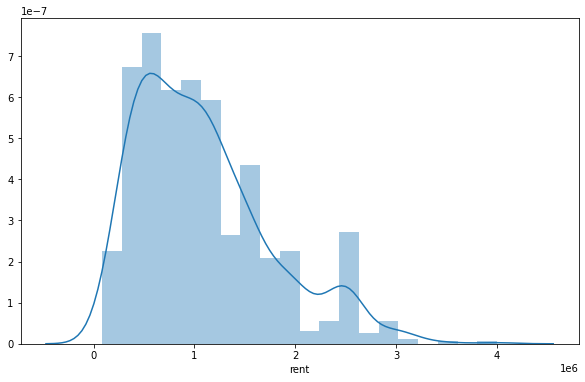

In [19]:
# use a distplot for continuous labels to see how the values are distributed across the data
plt.figure(figsize=(10, 6))
sns.distplot(df['rent'])

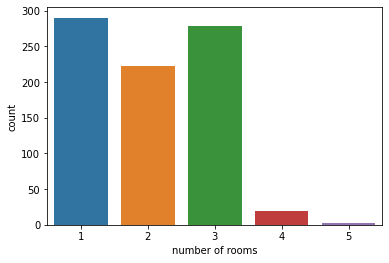

In [20]:
sns.countplot(df['number of rooms'])

In [21]:
# compare label (price) to features using correlations
df.corr()['rent'].sort_values()

serviced               0.034704
furnished              0.076966
number of bathrooms    0.643467
number of toilets      0.695056
number of rooms        0.745051
rent                   1.000000
Name: rent, dtype: float64

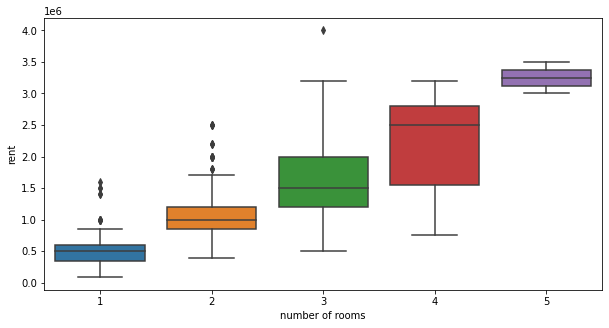

In [22]:
# explore highly correlated features with your label using a scatter plot
plt.figure(figsize=(10, 5))
sns.boxplot(y='rent', x='number of rooms', data=df)

## Preprocessing

In [23]:
df = pd.get_dummies(df, columns=['city'], prefix='city')
df = pd.get_dummies(df, columns=['monthAdded'], prefix='monthAdded')

In [24]:
df.head()

,rent,number of rooms,serviced,furnished,number of bathrooms,number of toilets,city_Gbagada,city_Maryland,city_Surulere,city_Yaba,...,monthAdded_December,monthAdded_February,monthAdded_January,monthAdded_July,monthAdded_June,monthAdded_March,monthAdded_May,monthAdded_November,monthAdded_October,monthAdded_September
id,,,,,,,,,,,,,,,,,,,,,
0,400000,1,0,1,1,1,0,0,0,1,...,0,0,0,1,0,0,0,0,0,0
1,400000,1,0,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0
2,800000,1,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
3,500000,1,0,0,1,1,0,0,0,1,...,1,0,0,0,0,0,0,0,0,0
4,1300000,2,1,0,2,3,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X = df.drop("rent", axis=1).values
y = df['rent'].values

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [28]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Apply Model

In [29]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [30]:
model = Sequential()

# apply layers
model.add(Dense(21, activation='relu'))
model.add(Dense(21, activation='relu'))
model.add(Dense(21, activation='relu'))
model.add(Dense(21, activation='relu'))

# output later
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')

# fit the data
model.fit(
    X_train, y_train, 
    validation_data=(X_test, y_test), 
    batch_size=128,
    epochs=800)

Epoch 1/800
5/5 [==============================] - 1s 184ms/step - loss: 1768676567722.6667 - val_loss: 1519146893312.0000
Epoch 2/800
5/5 [==============================] - 0s 9ms/step - loss: 1741203483306.6667 - val_loss: 1519146369024.0000
Epoch 3/800
5/5 [==============================] - 0s 10ms/step - loss: 1783992745984.0000 - val_loss: 1519146106880.0000
Epoch 4/800
5/5 [==============================] - 0s 11ms/step - loss: 1662617234090.6667 - val_loss: 1519145320448.0000
Epoch 5/800
5/5 [==============================] - 0s 10ms/step - loss: 1686695815850.6667 - val_loss: 1519144665088.0000
Epoch 6/800
5/5 [==============================] - 0s 10ms/step - loss: 1655459020800.0000 - val_loss: 1519143747584.0000
Epoch 7/800
5/5 [==============================] - 0s 11ms/step - loss: 1709841732949.3333 - val_loss: 1519142567936.0000
Epoch 8/800
5/5 [==============================] - 0s 12ms/step - loss: 1644694317738.6667 - val_loss: 1519140995072.0000
Epoch 9/800
5/5 [=======

Epoch 68/800
5/5 [==============================] - 0s 10ms/step - loss: 1570683311445.3333 - val_loss: 1390525677568.0000
Epoch 69/800
5/5 [==============================] - 0s 10ms/step - loss: 1490521139882.6667 - val_loss: 1380089331712.0000
Epoch 70/800
5/5 [==============================] - 0s 9ms/step - loss: 1445984600064.0000 - val_loss: 1369024102400.0000
Epoch 71/800
5/5 [==============================] - 0s 10ms/step - loss: 1500627009536.0000 - val_loss: 1357240729600.0000
Epoch 72/800
5/5 [==============================] - 0s 9ms/step - loss: 1471210192896.0000 - val_loss: 1344750878720.0000
Epoch 73/800
5/5 [==============================] - 0s 9ms/step - loss: 1503768390314.6667 - val_loss: 1331535282176.0000
Epoch 74/800
5/5 [==============================] - 0s 10ms/step - loss: 1407728921258.6667 - val_loss: 1317836816384.0000
Epoch 75/800
5/5 [==============================] - 0s 11ms/step - loss: 1437821850965.3333 - val_loss: 1303298572288.0000
Epoch 76/800
5/5 [=

5/5 [==============================] - 0s 8ms/step - loss: 306879698261.3333 - val_loss: 261254479872.0000
Epoch 136/800
5/5 [==============================] - 0s 8ms/step - loss: 318159503360.0000 - val_loss: 260408688640.0000
Epoch 137/800
5/5 [==============================] - 0s 8ms/step - loss: 319611240448.0000 - val_loss: 259697246208.0000
Epoch 138/800
5/5 [==============================] - 0s 8ms/step - loss: 306587888298.6667 - val_loss: 259086761984.0000
Epoch 139/800
5/5 [==============================] - 0s 8ms/step - loss: 316793121450.6667 - val_loss: 258553118720.0000
Epoch 140/800
5/5 [==============================] - 0s 9ms/step - loss: 322834852522.6667 - val_loss: 258070085632.0000
Epoch 141/800
5/5 [==============================] - 0s 9ms/step - loss: 314692539733.3333 - val_loss: 257614413824.0000
Epoch 142/800
5/5 [==============================] - 0s 9ms/step - loss: 309074466133.3333 - val_loss: 257151352832.0000
Epoch 143/800
5/5 [===========================

Epoch 203/800
5/5 [==============================] - 0s 9ms/step - loss: 263649468416.0000 - val_loss: 227774840832.0000
Epoch 204/800
5/5 [==============================] - 0s 7ms/step - loss: 278335332352.0000 - val_loss: 227392716800.0000
Epoch 205/800
5/5 [==============================] - 0s 8ms/step - loss: 268472907093.3333 - val_loss: 226946514944.0000
Epoch 206/800
5/5 [==============================] - 0s 8ms/step - loss: 281224571562.6667 - val_loss: 226524299264.0000
Epoch 207/800
5/5 [==============================] - 0s 8ms/step - loss: 271608821077.3333 - val_loss: 226126004224.0000
Epoch 208/800
5/5 [==============================] - 0s 8ms/step - loss: 265799761920.0000 - val_loss: 225699971072.0000
Epoch 209/800
5/5 [==============================] - 0s 8ms/step - loss: 265102095701.3333 - val_loss: 225316388864.0000
Epoch 210/800
5/5 [==============================] - 0s 9ms/step - loss: 283418596693.3333 - val_loss: 225103380480.0000
Epoch 211/800
5/5 [=============

5/5 [==============================] - 0s 8ms/step - loss: 246771758421.3333 - val_loss: 202260135936.0000
Epoch 271/800
5/5 [==============================] - 0s 7ms/step - loss: 249023608149.3333 - val_loss: 201892888576.0000
Epoch 272/800
5/5 [==============================] - 0s 7ms/step - loss: 230495038122.6667 - val_loss: 201525854208.0000
Epoch 273/800
5/5 [==============================] - 0s 7ms/step - loss: 259171382613.3333 - val_loss: 201240166400.0000
Epoch 274/800
5/5 [==============================] - 0s 8ms/step - loss: 264888871594.6667 - val_loss: 200911142912.0000
Epoch 275/800
5/5 [==============================] - 0s 8ms/step - loss: 246949109760.0000 - val_loss: 200626421760.0000
Epoch 276/800
5/5 [==============================] - 0s 8ms/step - loss: 251382022144.0000 - val_loss: 200247803904.0000
Epoch 277/800
5/5 [==============================] - 0s 8ms/step - loss: 241492650666.6667 - val_loss: 199948320768.0000
Epoch 278/800
5/5 [===========================

Epoch 338/800
5/5 [==============================] - 0s 8ms/step - loss: 221895985834.6667 - val_loss: 181717467136.0000
Epoch 339/800
5/5 [==============================] - 0s 8ms/step - loss: 226957866325.3333 - val_loss: 181297594368.0000
Epoch 340/800
5/5 [==============================] - 0s 8ms/step - loss: 204295028736.0000 - val_loss: 180922826752.0000
Epoch 341/800
5/5 [==============================] - 0s 8ms/step - loss: 226753039018.6667 - val_loss: 180720599040.0000
Epoch 342/800
5/5 [==============================] - 0s 8ms/step - loss: 219574654293.3333 - val_loss: 180381401088.0000
Epoch 343/800
5/5 [==============================] - 0s 8ms/step - loss: 226638746965.3333 - val_loss: 180135952384.0000
Epoch 344/800
5/5 [==============================] - 0s 8ms/step - loss: 210077720576.0000 - val_loss: 179824918528.0000
Epoch 345/800
5/5 [==============================] - 0s 7ms/step - loss: 212371499690.6667 - val_loss: 179597017088.0000
Epoch 346/800
5/5 [=============

5/5 [==============================] - 0s 8ms/step - loss: 202792165376.0000 - val_loss: 166120030208.0000
Epoch 406/800
5/5 [==============================] - 0s 8ms/step - loss: 203018534912.0000 - val_loss: 165892046848.0000
Epoch 407/800
5/5 [==============================] - 0s 8ms/step - loss: 213554132309.3333 - val_loss: 165635407872.0000
Epoch 408/800
5/5 [==============================] - 0s 7ms/step - loss: 199020639573.3333 - val_loss: 165413765120.0000
Epoch 409/800
5/5 [==============================] - 0s 8ms/step - loss: 210861684053.3333 - val_loss: 165311234048.0000
Epoch 410/800
5/5 [==============================] - 0s 8ms/step - loss: 203685300906.6667 - val_loss: 165191008256.0000
Epoch 411/800
5/5 [==============================] - 0s 8ms/step - loss: 204967250602.6667 - val_loss: 164980260864.0000
Epoch 412/800
5/5 [==============================] - 0s 7ms/step - loss: 207489873237.3333 - val_loss: 164698669056.0000
Epoch 413/800
5/5 [===========================

Epoch 473/800
5/5 [==============================] - 0s 8ms/step - loss: 178281559381.3333 - val_loss: 155091943424.0000
Epoch 474/800
5/5 [==============================] - 0s 8ms/step - loss: 192750469120.0000 - val_loss: 154958725120.0000
Epoch 475/800
5/5 [==============================] - 0s 8ms/step - loss: 184809999018.6667 - val_loss: 154785087488.0000
Epoch 476/800
5/5 [==============================] - 0s 8ms/step - loss: 188870639616.0000 - val_loss: 154824654848.0000
Epoch 477/800
5/5 [==============================] - 0s 8ms/step - loss: 184470039210.6667 - val_loss: 154617479168.0000
Epoch 478/800
5/5 [==============================] - 0s 8ms/step - loss: 186604118016.0000 - val_loss: 154446233600.0000
Epoch 479/800
5/5 [==============================] - 0s 8ms/step - loss: 195961053184.0000 - val_loss: 154381107200.0000
Epoch 480/800
5/5 [==============================] - 0s 8ms/step - loss: 184400519168.0000 - val_loss: 154217807872.0000
Epoch 481/800
5/5 [=============

5/5 [==============================] - 0s 8ms/step - loss: 158827080362.6667 - val_loss: 148492877824.0000
Epoch 541/800
5/5 [==============================] - 0s 8ms/step - loss: 185269504682.6667 - val_loss: 148501004288.0000
Epoch 542/800
5/5 [==============================] - 0s 8ms/step - loss: 168959631360.0000 - val_loss: 148556955648.0000
Epoch 543/800
5/5 [==============================] - 0s 8ms/step - loss: 172382191616.0000 - val_loss: 148682850304.0000
Epoch 544/800
5/5 [==============================] - 0s 8ms/step - loss: 174516232192.0000 - val_loss: 148700561408.0000
Epoch 545/800
5/5 [==============================] - 0s 8ms/step - loss: 177276349098.6667 - val_loss: 148525842432.0000
Epoch 546/800
5/5 [==============================] - 0s 7ms/step - loss: 170297029973.3333 - val_loss: 148201635840.0000
Epoch 547/800
5/5 [==============================] - 0s 8ms/step - loss: 162851173717.3333 - val_loss: 148014153728.0000
Epoch 548/800
5/5 [===========================

Epoch 608/800
5/5 [==============================] - 0s 7ms/step - loss: 186056152405.3333 - val_loss: 144509403136.0000
Epoch 609/800
5/5 [==============================] - 0s 8ms/step - loss: 166630162432.0000 - val_loss: 144330194944.0000
Epoch 610/800
5/5 [==============================] - 0s 8ms/step - loss: 174227860138.6667 - val_loss: 144319807488.0000
Epoch 611/800
5/5 [==============================] - 0s 8ms/step - loss: 164300016298.6667 - val_loss: 144343711744.0000
Epoch 612/800
5/5 [==============================] - 0s 8ms/step - loss: 171428246869.3333 - val_loss: 144521953280.0000
Epoch 613/800
5/5 [==============================] - 0s 7ms/step - loss: 175459341653.3333 - val_loss: 144514416640.0000
Epoch 614/800
5/5 [==============================] - 0s 8ms/step - loss: 170478373546.6667 - val_loss: 144611639296.0000
Epoch 615/800
5/5 [==============================] - 0s 8ms/step - loss: 172484307626.6667 - val_loss: 144676978688.0000
Epoch 616/800
5/5 [=============

5/5 [==============================] - 0s 8ms/step - loss: 177531103914.6667 - val_loss: 142389854208.0000
Epoch 676/800
5/5 [==============================] - 0s 8ms/step - loss: 170833854464.0000 - val_loss: 142373044224.0000
Epoch 677/800
5/5 [==============================] - 0s 8ms/step - loss: 166844044629.3333 - val_loss: 142344077312.0000
Epoch 678/800
5/5 [==============================] - 0s 8ms/step - loss: 160515747840.0000 - val_loss: 142456995840.0000
Epoch 679/800
5/5 [==============================] - 0s 7ms/step - loss: 174061816490.6667 - val_loss: 142588788736.0000
Epoch 680/800
5/5 [==============================] - 0s 8ms/step - loss: 173595912874.6667 - val_loss: 142442315776.0000
Epoch 681/800
5/5 [==============================] - 0s 8ms/step - loss: 173141811200.0000 - val_loss: 142275346432.0000
Epoch 682/800
5/5 [==============================] - 0s 8ms/step - loss: 171428042069.3333 - val_loss: 142133329920.0000
Epoch 683/800
5/5 [===========================

Epoch 743/800
5/5 [==============================] - 0s 9ms/step - loss: 162790637568.0000 - val_loss: 141555892224.0000
Epoch 744/800
5/5 [==============================] - 0s 9ms/step - loss: 162195002709.3333 - val_loss: 141611892736.0000
Epoch 745/800
5/5 [==============================] - 0s 9ms/step - loss: 166109017429.3333 - val_loss: 141642219520.0000
Epoch 746/800
5/5 [==============================] - 0s 10ms/step - loss: 181636825088.0000 - val_loss: 141765787648.0000
Epoch 747/800
5/5 [==============================] - 0s 8ms/step - loss: 157776439978.6667 - val_loss: 141640482816.0000
Epoch 748/800
5/5 [==============================] - 0s 9ms/step - loss: 177576449365.3333 - val_loss: 141831700480.0000
Epoch 749/800
5/5 [==============================] - 0s 8ms/step - loss: 169560399872.0000 - val_loss: 141803421696.0000
Epoch 750/800
5/5 [==============================] - 0s 9ms/step - loss: 170868326400.0000 - val_loss: 141750583296.0000
Epoch 751/800
5/5 [============

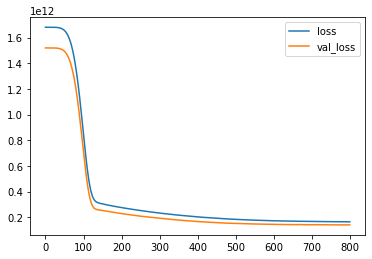

In [31]:
losses = pd.DataFrame(model.history.history)
losses.plot()

## Evaluation

In [32]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score

In [33]:
pred = model.predict(X_test)

In [34]:
np.sqrt(mean_squared_error(y_test, pred))

375892.2511593805

In [35]:
mean_absolute_error(y_test, pred)

290178.0825795658

In [36]:
df['rent'].describe()

count    8.110000e+02
mean     1.088612e+06
std      6.687547e+05
min      8.400000e+04
25%      5.500000e+05
50%      1.000000e+06
75%      1.500000e+06
max      4.000000e+06
Name: rent, dtype: float64

In [37]:
off_by = (mean_absolute_error(y_test, pred) / df['rent'].mean()) * 100
print("Based on our MAE we're off by {:2.4}%".format(off_by))

Based on our MAE we're off by 26.66%


In [38]:
explained_variance_score(y_test, pred)

0.6414843375837004

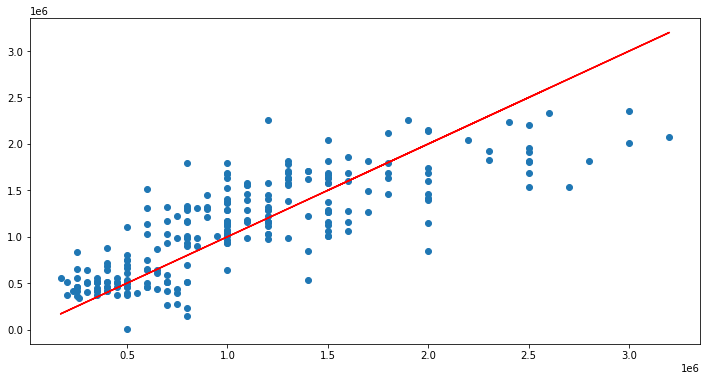

In [39]:
plt.figure(figsize=(12, 6))
plt.scatter(y_test, pred)
plt.plot(y_test, y_test, 'r')

## Using the model

In [43]:
bed1 = df[(df['number of rooms'] == 1) & (df['city_Yaba'] == 1)].iloc[1]
bed1_orig = bed1['rent']

bed1 = bed1.drop('rent')
bed1 = scaler.transform(bed1.values.reshape(-1, 21))

bed1_pred = model.predict(bed1)

print("Prediction for a 1 bedroom in Yaba")
print(bed1_orig)
print(bed1_pred[0][0])

Prediction for a 1 bedroom in Yaba
400000
511870.72


In [53]:
bed2 = df[(df['number of rooms'] == 2) & (df['city_Yaba'] == 1)].iloc[10]
bed2_orig = bed2['rent']

bed2 = bed2.drop('rent')
bed2 = scaler.transform(bed2.values.reshape(-1, 21))

bed2_pred = model.predict(bed2)

print("Prediction for a 2 bedroom in Yaba")
print(bed2_orig)
print(bed2_pred[0][0])

Prediction for a 2 bedroom in Yaba
1700000
1270598.1


## Final Notes

To improve this model we can add more features like

- Upstairs or Downstairs
- Using the images to get more features about the standard of the house